## Packages and data

In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from DTC import DTC
from data import getdata

In [2]:
# data processing

data = pd.read_csv("data/fishing.csv")

Lab = data["label"].values

for (i,lab) in enumerate(Lab):
    if lab.endswith("sailing"):
        Lab[i] = 0
    else:
        Lab[i] = 1

data["label"] = Lab

ids = data["id"].unique()
L = [len(data[data["id"]==iid]) for iid in ids]


D = []
for iid, l in zip(ids,L):
    
    d = data.loc[data["id"]==iid, ["signed_turn", "distance_gap", "euc_speed", "distanceToShore", "time_gap", "label"]]
    d.reset_index(drop=True, inplace=True)


    
    inds = np.argwhere(d["time_gap"].values > 600)
    inds = [ii[0] for ii in inds]
    if len(inds) > 0:
        
        D.append(d.loc[0:inds[0]-1, ["signed_turn", "distance_gap", "euc_speed", "distanceToShore", "time_gap", "label"]])
        for i in range(len(inds)-1):
            D.append(d.loc[inds[i]:inds[i]-1, ["signed_turn", "distance_gap", "euc_speed", "distanceToShore", "time_gap", "label"]])
        D.append(d.loc[inds[-1]:, ["signed_turn", "distance_gap", "euc_speed", "distanceToShore", "time_gap", "label"]])
    else:
        D.append(d.loc[:, ["signed_turn", "distance_gap", "euc_speed", "distanceToShore", "time_gap", "label"]])
    
D = [d for d in D if len(d) > 1000]
for d in D:
    d.reset_index(drop=True, inplace=True)
L = [len(d) for d in D]

for d in D:
    d.loc[d["euc_speed"] > 20, "euc_speed"] = 20
    d["euc_speed"] = d["euc_speed"] * 0.5144
    d.loc[d["distance_gap"] > 200, "distance_gap"] = 200
    d["signed_turn"] = d["signed_turn"] / 180 * np.pi
    

# features calculation
Fs = []
Lab = []
for d in D:
    speed = d["euc_speed"].values[1:]
    signed_turn = d["signed_turn"].values[1:]
    distance_gap = d["distance_gap"].values[1:]
    distanceToShore = d["distanceToShore"].values

    time_gap = d["time_gap"].values[1:]
    
    speed_gap = d["euc_speed"].diff().values[1:]
    speed_gap_ratio = speed_gap / time_gap
    distance_gap_ratio = distance_gap / time_gap
    signed_turn_ratio = signed_turn / time_gap
    
    distanceToShore_gap = np.diff(distanceToShore) / time_gap


    Fs.append(np.array([speed.tolist(), signed_turn.tolist(), distance_gap.tolist(), distanceToShore[1:].tolist(), speed_gap.tolist(),
                       speed_gap_ratio.tolist(), distance_gap_ratio.tolist(), signed_turn_ratio.tolist(),
                       distanceToShore_gap.tolist()]).transpose(1,0))
    Lab.append(d["label"].values[1:])

L = [len(f) for f in Fs]
V = np.concatenate(Fs, axis=0)

Fs = [(fs - np.mean(V, axis=0)) / (np.std(V, axis=0)) for fs in Fs]

# segmentation
def sample(feature, lab, window_size):
    Flag = []
    Fs_p = []
    # Fs_f = []
    L_p = []
    # L_f = []
    P = []
    Lab_p = []
    # Lab_f = []
    for i in range(len(feature)):
        f = feature[i]
        l = lab[i]
        p = []
        for j in range(window_size, l.shape[0]-window_size, window_size):
            Fs_p.append(f[j-window_size:j,:])
            L_p.append(l[j-window_size:j])
            if len(np.unique(l[j-window_size:j])) == 2:
                if np.sum(l[j-window_size:j]==0) > np.sum(l[j-window_size:j]==1):
                    Lab_p.append(0)
                else:
                    Lab_p.append(1)
            else:
                if np.unique(l[j-window_size:j]) == 0:
                    Lab_p.append(0)
                else:
                    Lab_p.append(1)
            Flag.append(i)
            p.append(j)
        P.append(p)
    return Fs_p, L_p, Flag, P, np.array(Lab_p)



Fs_p, L_p, Flag, P, Lab_p = sample(Fs, Lab, 100)

Fs_p = np.stack(Fs_p, axis=0)
L_p = np.stack(L_p, axis=0)

Fs_p = torch.tensor(Fs_p)
L_p =torch.tensor(L_p.astype(np.int32))
Lab_p = torch.tensor(Lab_p.astype(np.int32))
Fs_p = Fs_p.float()

# split training and test
class TrajDataset(Dataset):
    def __init__(self, Fs_p, L_p, Lab_p):
        self.Fs_p = Fs_p
        self.L_p = L_p
        self.Lab_p = Lab_p

    def __len__(self):
        return len(self.Fs_p)

    def __getitem__(self, index):
        return self.Fs_p[index], self.L_p[index], self.Lab_p[i]



train_size = int(Fs_p.shape[0] * 0.6)
indexs = np.random.choice(Fs_p.shape[0], size=train_size, replace = False).tolist()


train_set = TrajDataset(Fs_p[indexs],  L_p[indexs], Lab_p[indexs])

train_data = DataLoader(dataset=train_set,batch_size=1000,shuffle=True)

## Model Architecture

In [7]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        self.res = nn.Linear(n_inputs, n_outputs)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        out = self.net(x)
        res = self.res(torch.permute(x,(0,2,1)))
        return out + torch.permute(res, (0,2,1))


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, dila = True, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            if dila:
                dilation_size = 2 ** i
            else:
                dilation_size = 1
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        X = []
        x = torch.permute(x, (0, 2, 1))
        for la in self.network:
            x = la(x)
            X.append(torch.permute(x, (0, 2, 1)))
        return torch.permute(x, (0, 2, 1)), X

In [8]:
class DRNN(nn.Module):

    def __init__(self, n_input, n_hiddens, dila=True, dropout=0, cell_type="GRU", batch_first=True):
        super().__init__()

        n_layers = len(n_hiddens)
        if dila:
            self.dilations = [2 ** i for i in range(n_layers)]
        else:
            self.dilations = [1] * n_layers
        self.cell_type = cell_type
        self.batch_first = batch_first

        layers = []
        if self.cell_type == "GRU":
            cell = nn.GRU
        elif self.cell_type == "RNN":
            cell = nn.RNN
        elif self.cell_type == "LSTM":
            cell = nn.LSTM
        else:
            raise NotImplementedError

        for i in range(n_layers):
            if i == 0:
                c = cell(n_input, n_hiddens[i], dropout=dropout)
            else:
                c = cell(n_hiddens[i-1], n_hiddens[i], dropout=dropout)
            layers.append(c)
        self.cells = nn.Sequential(*layers)

    def forward(self, inputs, hidden=None):
        if self.batch_first:
            inputs = inputs.transpose(1, 0)
        outputs = []
        for i, (cell, dilation) in enumerate(zip(self.cells, self.dilations)):
            if hidden is None:
                inputs, _ = self.drnn_layer(cell, inputs, dilation)
            else:
                inputs, hidden[i] = self.drnn_layer(cell, inputs, dilation, hidden[i])
            if self.batch_first:
                outputs.append(inputs.transpose(1, 0))
            else:
                outputs.append(inputs)
        if self.batch_first:
            inputs = inputs.transpose(1, 0)
        return inputs, outputs

    def drnn_layer(self, cell, inputs, rate, hidden=None):
        n_steps = len(inputs)
        batch_size = inputs[0].size(0)
        hidden_size = cell.hidden_size

        inputs, _ = self._pad_inputs(inputs, n_steps, rate)
        dilated_inputs = self._prepare_inputs(inputs, rate)

        if hidden is None:
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size)
        else:
            hidden = self._prepare_inputs(hidden, rate)
            dilated_outputs, hidden = self._apply_cell(dilated_inputs, cell, batch_size, rate, hidden_size, hidden)

        splitted_outputs = self._split_outputs(dilated_outputs, rate)
        outputs = self._unpad_outputs(splitted_outputs, n_steps)
        return outputs, hidden

    def init_hidden(self, batch_size, hidden_dim):
        hidden = torch.zeros(batch_size, hidden_dim)
        if self.cell_type == "LSTM":
            memory = torch.zeros(batch_size, hidden_dim)
            return (hidden, memory)
        else:
            return hidden

    def _prepare_inputs(self, inputs, rate):
        dilated_inputs = torch.cat([inputs[j::rate, :, :] for j in range(rate)], 1)
        return dilated_inputs

    def _pad_inputs(self, inputs, n_steps, rate):
        is_even = (n_steps % rate) == 0

        if not is_even:
            dilated_steps = n_steps // rate + 1

            zeros_ = torch.zeros(dilated_steps * rate - inputs.size(0), inputs.size(1),inputs.size(2))
            inputs = torch.cat((inputs, zeros_))
        else:
            dilated_steps = n_steps // rate

        return inputs, dilated_steps

    def _split_outputs(self, dilated_outputs, rate):
        batchsize = dilated_outputs.size(1) // rate

        blocks = [dilated_outputs[:, i * batchsize: (i + 1) * batchsize, :] for i in range(rate)]
        interleaved = torch.stack(blocks).transpose(1, 0).contiguous()
        interleaved = interleaved.view(dilated_outputs.size(0) * rate, batchsize, dilated_outputs.size(2))

        return interleaved

    def _unpad_outputs(self, splitted_outputs, n_steps):
        return splitted_outputs[:n_steps]

    def _apply_cell(self, dilated_inputs, cell, batch_size, rate, hidden_size, hidden=None):
        if hidden is None:
            if self.cell_type == 'LSTM':
                c, m = self.init_hidden(batch_size * rate, hidden_size)
                hidden = (c.unsqueeze(0), m.unsqueeze(0))
            else:
                hidden = self.init_hidden(batch_size * rate, hidden_size).unsqueeze(0)

        dilated_outputs, hidden = cell(dilated_inputs, hidden)

        return dilated_outputs, hidden

In [9]:
class selfAttention(nn.Module):
    def __init__(self, num_attention_heads, input_size, hidden_size):
        super().__init__()
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                "the hidden size %d is not a multiple of the number of attention heads"
                "%d" % (hidden_size, num_attention_heads)
            )
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = hidden_size

        self.key_layer = nn.Linear(input_size, hidden_size)
        self.query_layer = nn.Linear(input_size, hidden_size)
        self.value_layer = nn.Linear(input_size, hidden_size)
        self.inita()

    def inita(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
    def trans_to_multiple_heads(self, x):
        new_size = x.size()[ : -1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_size)
        return x.permute(0, 2, 1, 3)

    def forward(self, x):
        key = self.key_layer(x)
        query = self.query_layer(x)
        value = self.value_layer(x)

        key_heads = self.trans_to_multiple_heads(key)
        query_heads = self.trans_to_multiple_heads(query)
        value_heads = self.trans_to_multiple_heads(value)

        attention_scores = torch.matmul(query_heads, key_heads.permute(0, 1, 3, 2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        attention_probs = F.softmax(attention_scores, dim = -1)

        context = torch.matmul(attention_probs, value_heads)
        context = context.permute(0, 2, 1, 3).contiguous()
        new_size = context.size()[ : -2] + (self.all_head_size , )
        context = context.view(*new_size)
        return context

In [10]:
class encoder(nn.Module):
    def __init__(self, num_inputs=9, num_channels=[16, 32, 64, 32, 16], rnn_dim = 16, num_attention_heads=4, hidden_dim=32, combination=False, base_type=0):
        super().__init__()
        self.combination = combination
        self.base_type = base_type
        if base_type == 0:
            self.feature = TemporalConvNet(num_inputs, num_channels)
        else:
            self.feature = DRNN(num_inputs, num_channels)

        self.mlp = nn.Linear(sum(num_channels), num_channels[-1])
        self.rnn = nn.RNN(hidden_dim, rnn_dim, batch_first=True)
        self.attention = selfAttention(num_attention_heads, num_channels[-1], hidden_dim)

    def forward(self, x):
        feature, features = self.feature(x)
        if self.combination:
            feature = self.mlp(torch.concat(features, dim=-1))
        feature = self.attention(feature)
        feature, _ = self.rnn(feature)
        return feature

In [11]:
class Baseline(nn.Module):
    def __init__(self, base_encoder, num_inputs=9, num_channels=[16, 32, 64, 32, 16], rnn_dim = 16, num_attention_heads=4, hidden_dim=32, m=0.999, T=0.07, dila=True, combination=True, base_type=0):
        super().__init__()
        self.m = m
        self.T = T

        self.encoder = base_encoder(num_inputs, num_channels, rnn_dim, num_attention_heads, hidden_dim, combination, base_type)

        channels = num_channels.copy()
        channels.reverse()
        channels.append(num_inputs)
        if self.encoder.base_type == 0:
            self.decoder = TemporalConvNet(rnn_dim, channels, dila=False)
        else:
            self.decoder = DRNN(rnn_dim, channels, dila=False)

    def forward(self, xh):
        hs = self.encoder(xh)
        return hs

    def fit(self, fh):
        hs = self(fh)
        fh_d,_ = self.decoder(hs)
        loss = torch.mean(torch.sum(torch.pow(fh - fh_d, 2), dim=-1))
        return loss

## Model Instantiation

In [28]:
# model1：tcn
m1 = Baseline(encoder, base_type=0, combination=False)
# model2：tcn + combination
m2 = Baseline(encoder, base_type=0, combination=True)
# model3：tcn + distance calculation
params3 = dict(
    input_dim=9,
    num_channels=[16, 32, 64, 32, 16],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=0,
    combination=False
)
m3 = DTC(**params3)
# model4：tcn + combination + distance calculation
params4 = dict(
    input_dim=9,
    num_channels=[16, 32, 64, 32, 16],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=0,
    combination=True
)
m4 = DTC(**params4)
# model5：drnn
m5 = Baseline(encoder, base_type=1, combination=False)
# model6：drnn + combination
m6 = Baseline(encoder, base_type=1, combination=True)
# model7：drnn + distance calculation
params7 = dict(
    input_dim=9,
    num_channels=[16, 32, 64, 32, 16],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=1,
    combination=False
)
m7 = DTC(**params7)
# model8：drnn + combination + distance calculation
params8 = dict(
    input_dim=9,
    num_channels=[16, 32, 64, 32, 16],
    hidden_dim=32,
    num_heads=4,
    cluster_num=2,
    similarity="EUC",
    base_type=1,
    combination=True
)
m8 = DTC(**params8)

In [54]:
LL_p = L_p.detach().numpy()
Ls = Lab_p.detach().numpy()
data = pd.read_csv("data/fishing.csv")

Lab = data["label"].values

for (i,lab) in enumerate(Lab):
    if lab.endswith("sailing"):
        Lab[i] = 0
    else:
        Lab[i] = 1

data["label"] = Lab

ids = data["id"].unique()
L = [len(data[data["id"]==iid]) for iid in ids]

D = []

for iid, l in zip(ids,L):
    
    d = data.loc[data["id"]==iid, ["longitude", "latitude","time_gap", "label"]]
    d.reset_index(drop=True, inplace=True)


    
    inds = np.argwhere(d["time_gap"].values > 600)
    inds = [ii[0] for ii in inds]
    if len(inds) > 0:
        D.append(d.loc[0:inds[0]-1, ["longitude", "latitude", "label"]])
        for i in range(len(inds)-1):
            D.append(d.loc[inds[i]:inds[i]-1, ["longitude", "latitude", "label"]])
        D.append(d.loc[inds[-1]:, ["longitude", "latitude", "label"]])
    else:
        D.append(d.loc[:, ["longitude", "latitude", "label"]])
D = [d for d in D if len(d) > 1000]
for d in D:
    d.reset_index(drop=True, inplace=True)
    
DD = []
for i, (d, p) in enumerate(zip(D, P)):
    d = d[:p[-1]]
    d["MMSI"] = i
    DD.append(d)
DD = pd.concat(DD)

### model1

In [15]:
# m1.load_state_dict(torch.load("parameters/baseline.pkl"))

<All keys matched successfully>

In [16]:
Hs1 = []
for i in range(0, 4):
    m1.eval()
    hs1 = m1(Fs_p[i * 2000:(i + 1) * 2000])
    hs1 = hs1[:,-1,:].squeeze()
    Hs1.append(hs1.detach().numpy())

m1.eval()
hs1 = m1(Fs_p[4 * 2000:])
hs1 = hs1[:,-1,:].squeeze()
Hs1.append(hs1.detach().numpy())

Hs1 = np.concatenate(Hs1, axis=0)

In [38]:
color = np.array(["dodgerblue", "darkorange"])

In [18]:
tsne1 = TSNE(n_components=2, init='pca', random_state=0)
X_tsne1 = tsne1.fit_transform(Hs1)

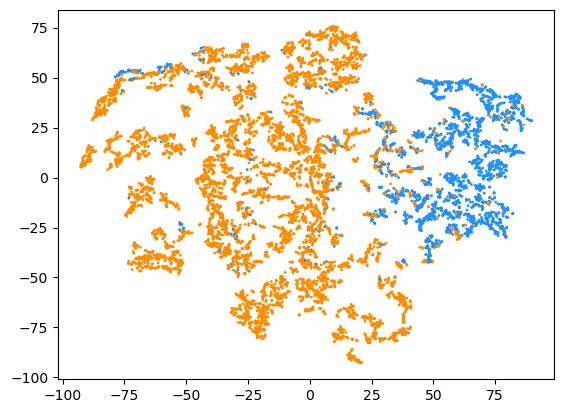

In [39]:
plt.scatter(X_tsne1[:,0],X_tsne1[:,1], c = color[np.array(Lab_p)], s=1)

In [40]:
n_clusters = 2
cluster1 = KMeans(n_clusters = n_clusters, random_state = 0).fit(Hs1)

y_pred1 = cluster1.labels_

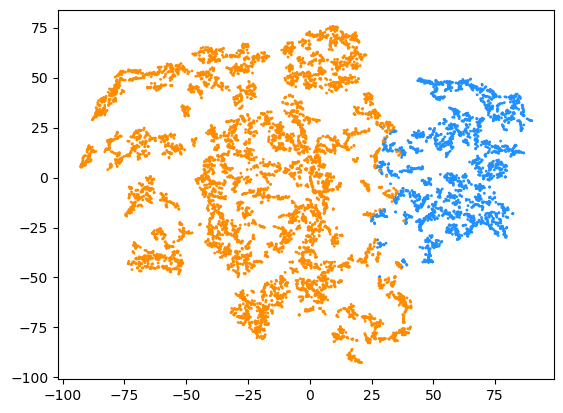

In [41]:
plt.scatter(X_tsne1[:,0],X_tsne1[:,1], c = color[np.array(y_pred1)], s=1)

In [42]:
np.sum(y_pred1 == np.array(Lab_p)) / len(y_pred1)

0.9313800239625313

In [43]:
Y_pred1 = []
for i in y_pred1:
    if i == 0:
        Y_pred1.append([0] * 100)
    else:
        Y_pred1.append([1] * 100)

In [44]:
np.sum(Y_pred1 == LL_p) / (LL_p.shape[0] * LL_p.shape[1])

0.9284010456377301

In [46]:
Y_pred1 = np.stack(Y_pred1, axis=0)

y_true = LL_p.reshape(-1)
pred1 = Y_pred1.reshape(-1)


accuracy = accuracy_score(y_true, pred1)
print("Accuracy:", accuracy)


conf_matrix = confusion_matrix(y_true, pred1)
print("Confusion Matrix:")
print(conf_matrix)


precision = precision_score(y_true, pred1)
recall = recall_score(y_true, pred1)
f1 = f1_score(y_true, pred1)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


fpr, tpr, thresholds = roc_curve(y_true, pred1)
roc_auc = roc_auc_score(y_true, pred1)
print("AUC:", roc_auc)

Accuracy: 0.9284010456377301
Confusion Matrix:
[[195314  35449]
 [ 30286 657051]]
Precision: 0.9488101083032491
Recall: 0.9559371894718312
F1 Score: 0.9523603150227166
AUC: 0.9011603542467556


In [45]:
lab_true = np.array(Lab_p)
lab_pred = np.array(y_pred1)

le_true = np.array(["sailing"] * len(lab_true))
# le_true[lab_true == 0] = "sailing"
le_true[lab_true == 1] = "fishing"

le_pred = np.array(["sailing"] * len(lab_pred))
# le_pred[lab_pred == 0] = "sailing"
le_pred[lab_pred == 1] = "fishing"

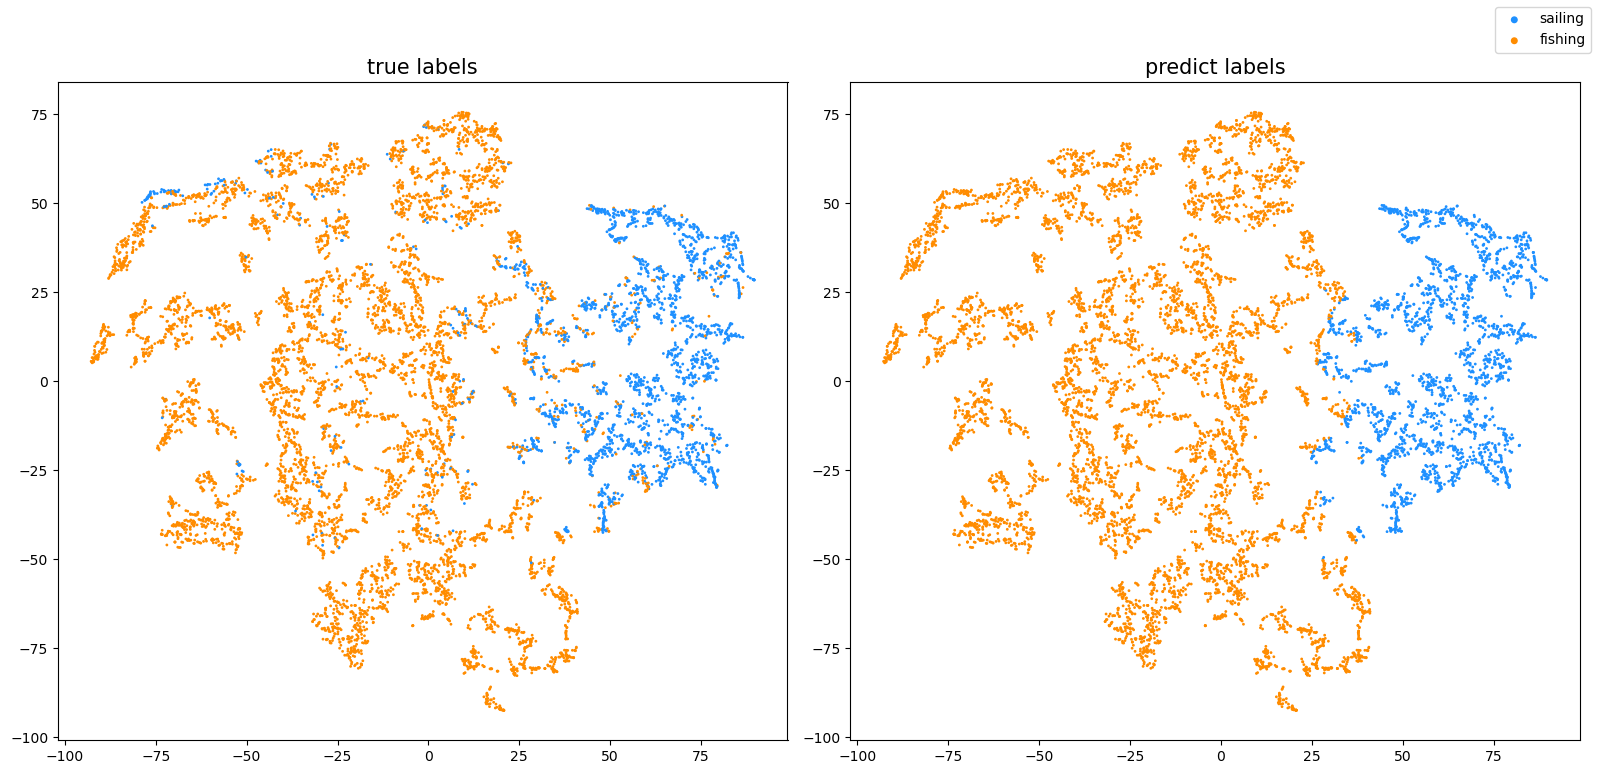

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(X_tsne1[:,0],X_tsne1[:,1], c = color[lab_true], s=1)
ax[0].set_title("true labels", fontsize=15)
# ax[0].legend()
ax[1].scatter(X_tsne1[:,0],X_tsne1[:,1], c = color[lab_pred], s=1)
ax[1].set_title("predict labels", fontsize=15)
# ax[1].legend(labels=le_pred)

# fig.tight_layout()
fig.legend(labels=np.array(["sailing", "fishing"]), loc='upper right', markerscale=4)
# fig.suptitle("Clustering results for TCN blocks without combination operation")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [89]:
DD["lab_pre1"] = pred1.reshape(-1)

### model2

In [47]:
# m2.load_state_dict(torch.load("parameters/baseline_com_1.pkl"))

<All keys matched successfully>

In [48]:
Hs2 = []
for i in range(0, 4):
    m2.eval()
    hs2 = m2(Fs_p[i * 2000:(i + 1) * 2000])
    hs2 = hs2[:,-1,:].squeeze()
    Hs2.append(hs2.detach().numpy())

m2.eval()
hs2 = m2(Fs_p[4 * 2000:])
hs2 = hs2[:,-1,:].squeeze()
Hs2.append(hs2.detach().numpy())

Hs2 = np.concatenate(Hs2, axis=0)

In [49]:
tsne2 = TSNE(n_components=2, init='pca', random_state=0)
X_tsne2 = tsne2.fit_transform(Hs2)

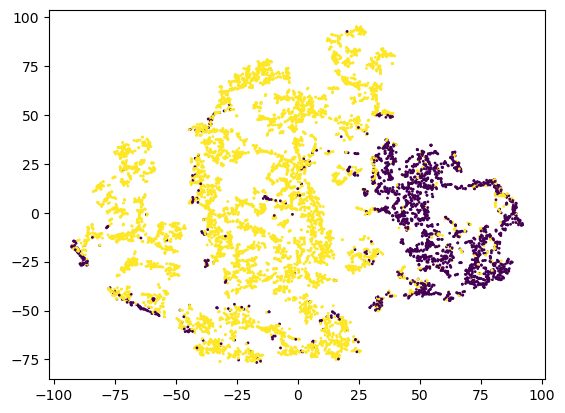

In [23]:
plt.scatter(X_tsne2[:,0],X_tsne2[:,1], c = np.array(Lab_p), s=1)

In [50]:
n_clusters = 2
cluster2 = KMeans(n_clusters = n_clusters, random_state = 0).fit(Hs2)

y_pred2 = cluster2.labels_

In [51]:
y_pred2[y_pred2==0] = 2
y_pred2[y_pred2==1] = 0
y_pred2[y_pred2==2] = 1

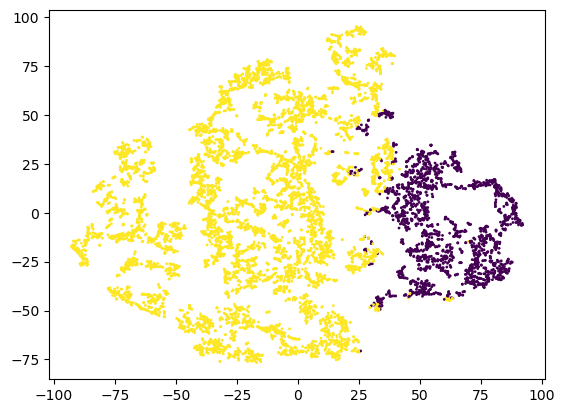

In [26]:
plt.scatter(X_tsne2[:,0],X_tsne2[:,1], c = np.array(y_pred2), s=1)

In [80]:
np.sum(y_pred2 == np.array(Lab_p)) / len(y_pred2)

0.90719965145409

In [81]:
Y_pred2 = []
for i in y_pred2:
    if i == 0:
        Y_pred2.append([0] * 100)
    else:
        Y_pred2.append([1] * 100)

In [83]:
np.sum(Y_pred2 == LL_p) / (LL_p.shape[0] * LL_p.shape[1])

0.9050702537849907

In [84]:
Y_pred2 = np.stack(Y_pred2, axis=0)

y_true = LL_p.reshape(-1)
pred2 = Y_pred2.reshape(-1)


accuracy = accuracy_score(y_true, pred2)
print("Accuracy:", accuracy)


conf_matrix = confusion_matrix(y_true, pred2)
print("Confusion Matrix:")
print(conf_matrix)


precision = precision_score(y_true, pred2)
recall = recall_score(y_true, pred2)
f1 = f1_score(y_true, pred2)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


fpr, tpr, thresholds = roc_curve(y_true, pred2)
roc_auc = roc_auc_score(y_true, pred2)
print("AUC:", roc_auc)

Accuracy: 0.9050702537849907
Confusion Matrix:
[[175704  55059]
 [ 32096 655241]]
Precision: 0.9224848655497677
Recall: 0.9533038378553752
F1 Score: 0.9376411757845563
AUC: 0.8573541978892196


In [52]:
lab_true = np.array(Lab_p)
lab_pred = np.array(y_pred2)

le_true = np.array(["sailing"] * len(lab_true))
# le_true[lab_true == 0] = "sailing"
le_true[lab_true == 1] = "fishing"

le_pred = np.array(["sailing"] * len(lab_pred))
# le_pred[lab_pred == 0] = "sailing"
le_pred[lab_pred == 1] = "fishing"

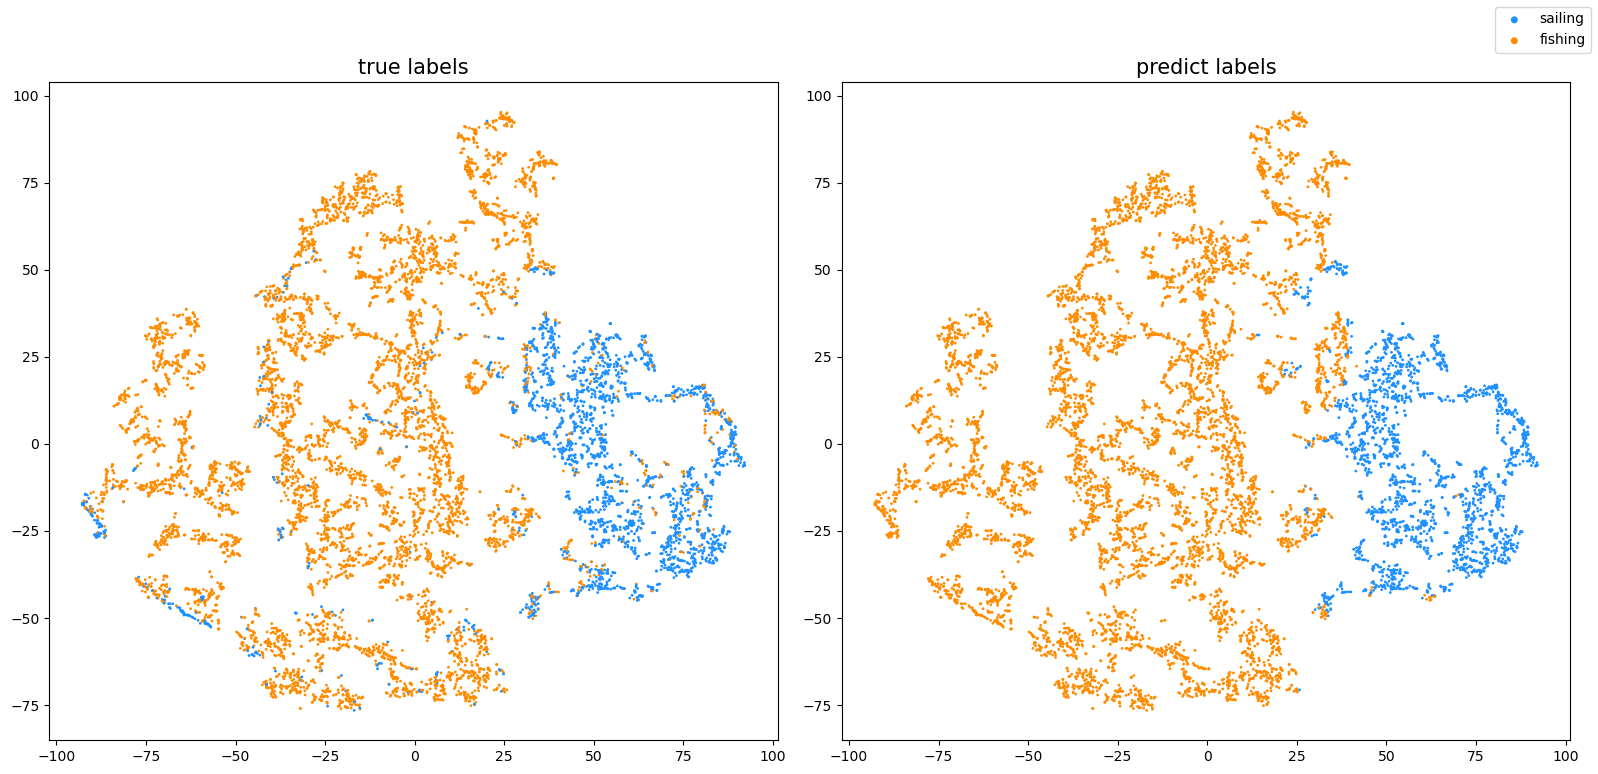

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(X_tsne2[:,0],X_tsne2[:,1], c = color[lab_true], s=1)
ax[0].set_title("true labels", fontsize=15)
# ax[0].legend()
ax[1].scatter(X_tsne2[:,0],X_tsne2[:,1], c = color[lab_pred], s=1)
ax[1].set_title("predict labels", fontsize=15)
# ax[1].legend(labels=le_pred)

# fig.tight_layout()
fig.legend(labels=np.array(["sailing", "fishing"]), loc='upper right', markerscale=4)
# fig.suptitle("Clustering results for TCN blocks without combination operation")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


In [90]:
DD["lab_pre2"] = pred2.reshape(-1)

### model3

In [54]:
# m3.load_state_dict(torch.load("parameters/model_tcn_dis4.pkl"))

<All keys matched successfully>

In [55]:
Hs3 = []
for i in range(0, 4):
    m3.eval()
    hs3 = m3(Fs_p[i * 2000:(i + 1) * 2000])
    hs3 = hs3[:,-1,:].squeeze()
    Hs3.append(hs3.detach().numpy())

m3.eval()
hs3 = m3(Fs_p[4 * 2000:])
hs3 = hs3[:,-1,:].squeeze()
Hs3.append(hs3.detach().numpy())

Hs3 = np.concatenate(Hs3, axis=0)

In [56]:
tsne3 = TSNE(n_components=2, init='pca', random_state=0)
X_tsne3 = tsne3.fit_transform(Hs3)

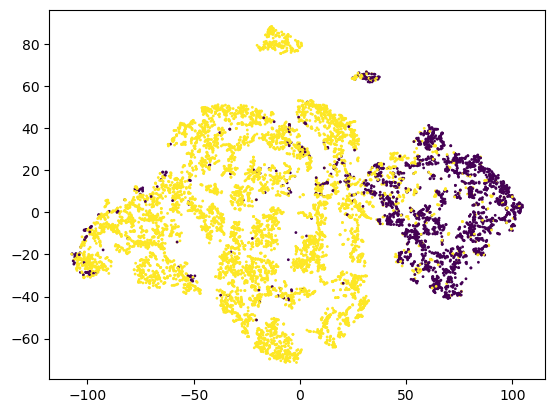

In [30]:
plt.scatter(X_tsne3[:,0],X_tsne3[:,1], c = np.array(Lab_p), s=1)

In [57]:
m3.eval()
y_pred3 = np.argmax(m3.sim(torch.tensor(Hs3)).detach().numpy(), axis=-1)

In [58]:
y_pred3[y_pred3==0] = 2
y_pred3[y_pred3==1] = 0
y_pred3[y_pred3==2] = 1

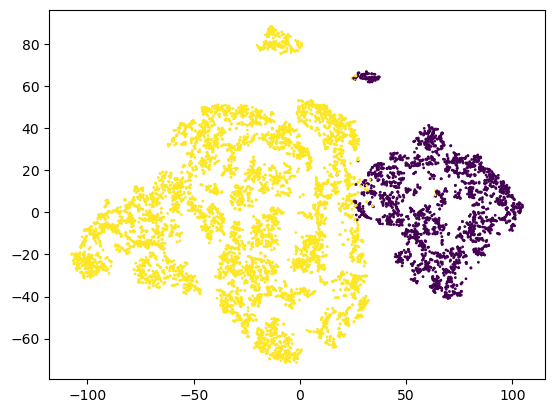

In [34]:
plt.scatter(X_tsne3[:,0],X_tsne3[:,1], c = np.array(y_pred3), s=1)

In [165]:
np.sum(y_pred3 == np.array(Lab_p)) / len(y_pred3)

0.9212504084522383

In [166]:
Y_pred3 = []
for i in y_pred3:
    if i == 0:
        Y_pred3.append([0] * 100)
    else:
        Y_pred3.append([1] * 100)

In [167]:
np.sum(Y_pred3 == LL_p) / (LL_p.shape[0] * LL_p.shape[1])

0.9190186254220674

In [168]:
Y_pred3 = np.stack(Y_pred3, axis=0)

y_true = LL_p.reshape(-1)
pred3 = Y_pred3.reshape(-1)


accuracy = accuracy_score(y_true, pred3)
print("Accuracy:", accuracy)


conf_matrix = confusion_matrix(y_true, pred3)
print("Confusion Matrix:")
print(conf_matrix)

precision = precision_score(y_true, pred3)
recall = recall_score(y_true, pred3)
f1 = f1_score(y_true, pred3)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


fpr, tpr, thresholds = roc_curve(y_true, pred3)
roc_auc = roc_auc_score(y_true, pred3)
print("AUC:", roc_auc)

Accuracy: 0.9190186254220674
Confusion Matrix:
[[204757  26006]
 [ 48343 638994]]
Precision: 0.9608932330827068
Recall: 0.9296662335942921
F1 Score: 0.9450218399703624
AUC: 0.9084852620717351


In [59]:
lab_true = np.array(Lab_p)
lab_pred = np.array(y_pred3)

le_true = np.array(["sailing"] * len(lab_true))
# le_true[lab_true == 0] = "sailing"
le_true[lab_true == 1] = "fishing"

le_pred = np.array(["sailing"] * len(lab_pred))
# le_pred[lab_pred == 0] = "sailing"
le_pred[lab_pred == 1] = "fishing"

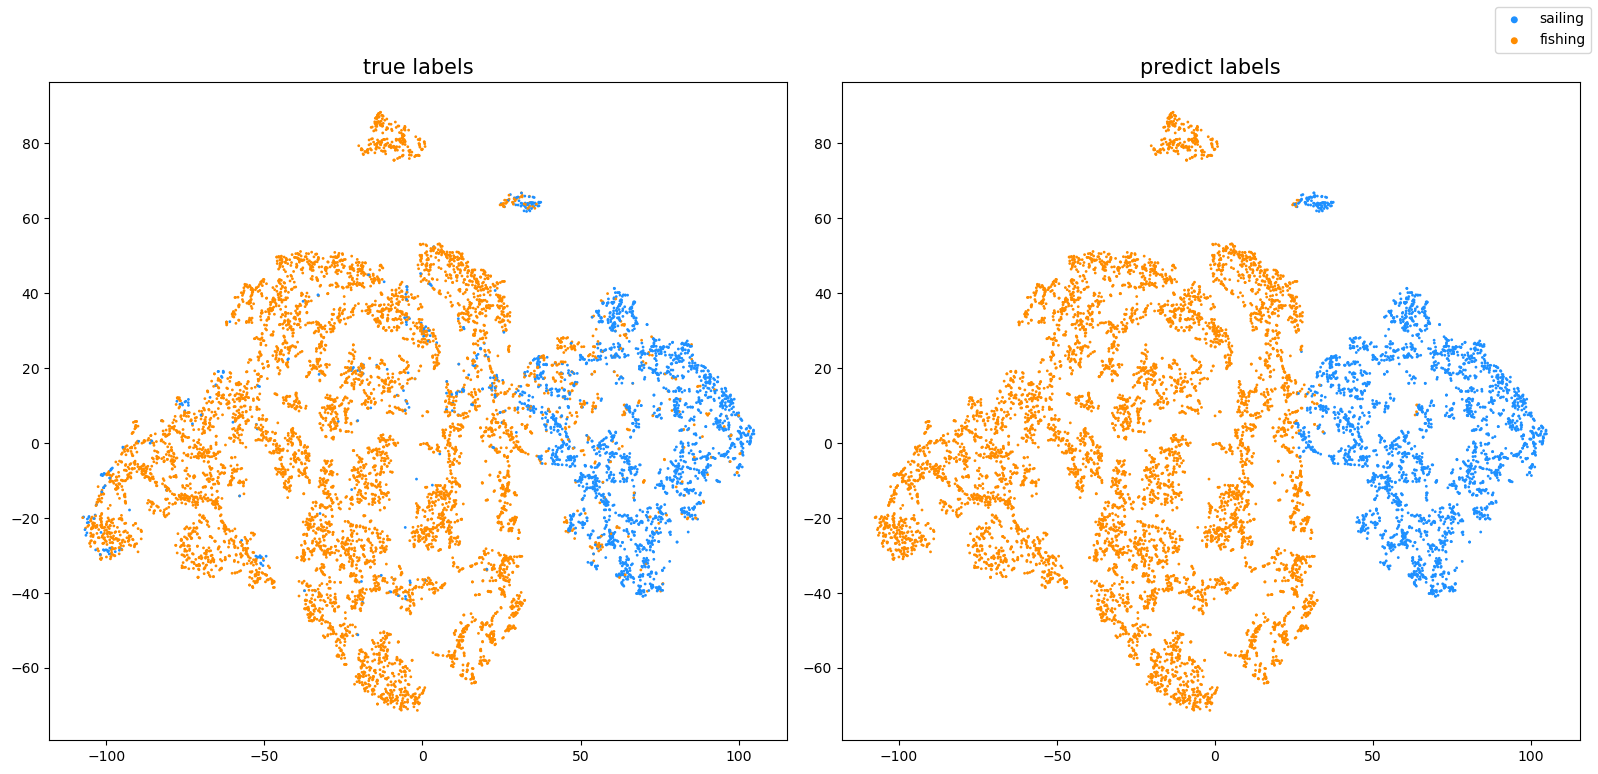

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(X_tsne3[:,0],X_tsne3[:,1], c = color[lab_true], s=1)
ax[0].set_title("true labels", fontsize=15)
# ax[0].legend()
ax[1].scatter(X_tsne3[:,0],X_tsne3[:,1], c = color[lab_pred], s=1)
ax[1].set_title("predict labels", fontsize=15)
# ax[1].legend(labels=le_pred)

# fig.tight_layout()
fig.legend(labels=np.array(["sailing", "fishing"]), loc='upper right', markerscale=4)
# fig.suptitle("Clustering results for TCN blocks without combination operation")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [171]:
DD["lab_pre3"] = pred3.reshape(-1)

### model4

In [61]:
# m4.load_state_dict(torch.load("parameters/model_tcn_com_dis1.pkl"))

<All keys matched successfully>

In [62]:
Hs4 = []
for i in range(0, 4):
    m4.eval()
    hs4 = m4(Fs_p[i * 2000:(i + 1) * 2000])
    hs4 = hs4[:,-1,:].squeeze()
    Hs4.append(hs4.detach().numpy())

m4.eval()
hs4 = m4(Fs_p[4 * 2000:])
hs4 = hs4[:,-1,:].squeeze()
Hs4.append(hs4.detach().numpy())

Hs4 = np.concatenate(Hs4, axis=0)

In [63]:
tsne4 = TSNE(n_components=2, init='pca', random_state=0)
X_tsne4 = tsne4.fit_transform(Hs4)

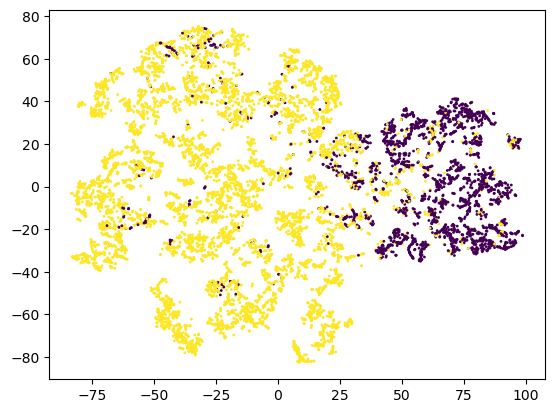

In [38]:
plt.scatter(X_tsne4[:,0],X_tsne4[:,1], c = np.array(Lab_p), s=1)

In [64]:
m4.eval()
y_pred4 = np.argmax(m4.sim(torch.tensor(Hs4)).detach().numpy(), axis=-1)

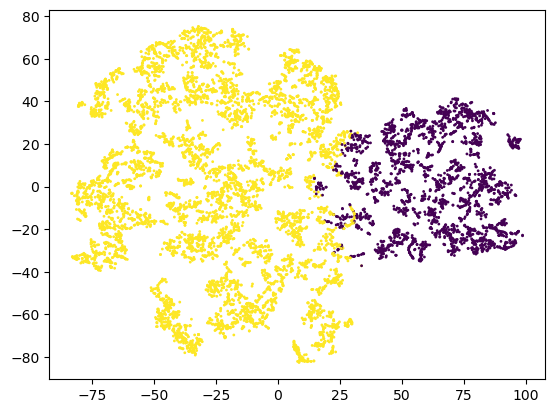

In [40]:
plt.scatter(X_tsne4[:,0],X_tsne4[:,1], c = np.array(y_pred4), s=1)

In [200]:
np.sum(y_pred4 == np.array(Lab_p)) / len(y_pred3)

0.921577170242893

In [201]:
Y_pred4 = []
for i in y_pred4:
    if i == 0:
        Y_pred4.append([0] * 100)
    else:
        Y_pred4.append([1] * 100)

In [202]:
np.sum(Y_pred4 == LL_p) / (LL_p.shape[0] * LL_p.shape[1])

0.9194281668663544

In [205]:
Y_pred4 = np.stack(Y_pred4, axis=0)

y_true = LL_p.reshape(-1)
pred4 = Y_pred4.reshape(-1)


accuracy = accuracy_score(y_true, pred4)
print("Accuracy:", accuracy)


conf_matrix = confusion_matrix(y_true, pred4)
print("Confusion Matrix:")
print(conf_matrix)


precision = precision_score(y_true, pred4)
recall = recall_score(y_true, pred4)
f1 = f1_score(y_true, pred4)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


fpr, tpr, thresholds = roc_curve(y_true, pred4)
roc_auc = roc_auc_score(y_true, pred4)
print("AUC:", roc_auc)

Accuracy: 0.9194281668663544
Confusion Matrix:
[[205295  25468]
 [ 48505 638832]]
Precision: 0.9616618997440916
Recall: 0.9294305413501673
F1 Score: 0.945271548500078
AUC: 0.9095331140901893


In [65]:
lab_true = np.array(Lab_p)
lab_pred = np.array(y_pred4)

le_true = np.array(["sailing"] * len(lab_true))
# le_true[lab_true == 0] = "sailing"
le_true[lab_true == 1] = "fishing"

le_pred = np.array(["sailing"] * len(lab_pred))
# le_pred[lab_pred == 0] = "sailing"
le_pred[lab_pred == 1] = "fishing"

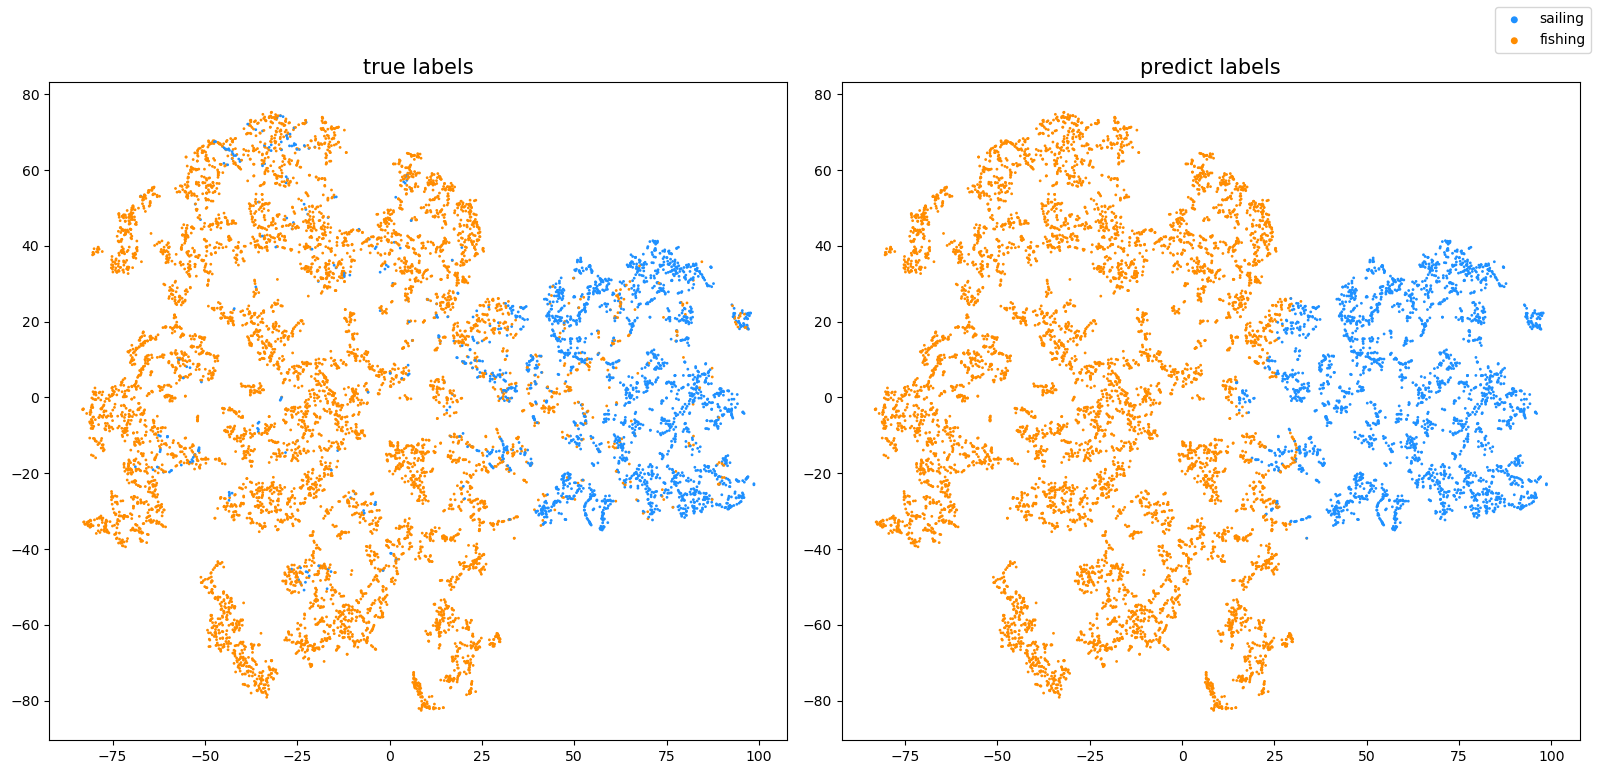

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(X_tsne4[:,0],X_tsne4[:,1], c = color[lab_true], s=1)
ax[0].set_title("true labels", fontsize=15)
# ax[0].legend()
ax[1].scatter(X_tsne4[:,0],X_tsne4[:,1], c = color[lab_pred], s=1)
ax[1].set_title("predict labels", fontsize=15)
# ax[1].legend(labels=le_pred)

# fig.tight_layout()
fig.legend(labels=np.array(["sailing", "fishing"]), loc='upper right', markerscale=4)
# fig.suptitle("Clustering results for TCN blocks without combination operation")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [208]:
DD["lab_pre4"] = pred4.reshape(-1)

### model5

In [67]:
# m5.load_state_dict(torch.load("parameters/baseline_DRNN.pkl"))

<All keys matched successfully>

In [68]:
Hs5 = []
for i in range(0, 4):
    m5.eval()
    hs5= m5(Fs_p[i * 2000:(i + 1) * 2000])
    hs5 = hs5[:,-1,:].squeeze()
    Hs5.append(hs5.detach().numpy())

m5.eval()
hs5 = m5(Fs_p[4 * 2000:])
hs5 = hs5[:,-1,:].squeeze()
Hs5.append(hs5.detach().numpy())

Hs5 = np.concatenate(Hs5, axis=0)

In [69]:
tsne5 = TSNE(n_components=2, init='pca', random_state=0)
X_tsne5 = tsne5.fit_transform(Hs5)

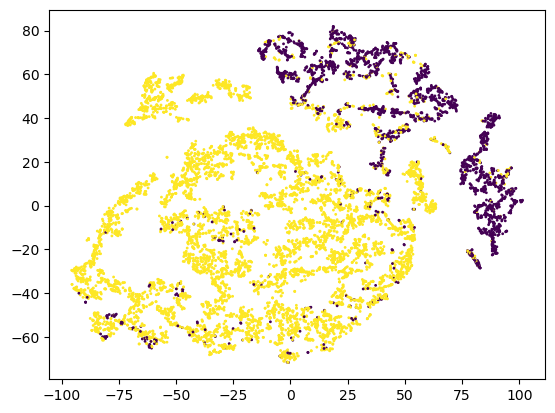

In [44]:
plt.scatter(X_tsne5[:,0],X_tsne5[:,1], c = np.array(Lab_p), s=1)

In [70]:
n_clusters = 2
cluster5 = KMeans(n_clusters = n_clusters, random_state = 0).fit(Hs5)

y_pred5 = cluster5.labels_

In [71]:
y_pred5[y_pred5==0] = 2
y_pred5[y_pred5==1] = 0
y_pred5[y_pred5==2] = 1

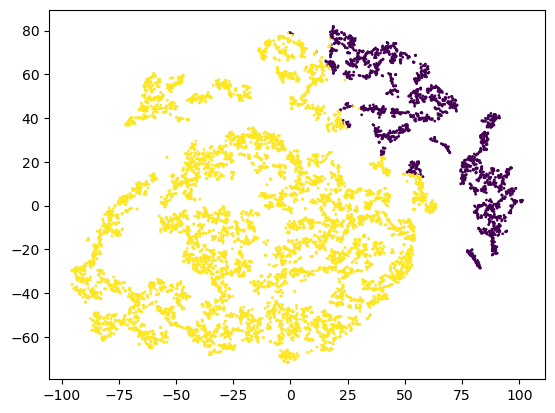

In [47]:
plt.scatter(X_tsne5[:,0],X_tsne5[:,1], c = np.array(y_pred5), s=1)

In [233]:
np.sum(y_pred5 == np.array(Lab_p)) / len(y_pred5)

0.8948916240060996

In [235]:
Y_pred5 = []
for i in y_pred5:
    if i == 0:
        Y_pred5.append([0] * 100)
    else:
        Y_pred5.append([1] * 100)

In [236]:
np.sum(Y_pred5 == LL_p) / (LL_p.shape[0] * LL_p.shape[1])

0.8938165777148459

In [237]:
Y_pred5 = np.stack(Y_pred5, axis=0)

y_true = LL_p.reshape(-1)
pred5 = Y_pred5.reshape(-1)


accuracy = accuracy_score(y_true, pred5)
print("Accuracy:", accuracy)


conf_matrix = confusion_matrix(y_true, pred5)
print("Confusion Matrix:")
print(conf_matrix)


precision = precision_score(y_true, pred5)
recall = recall_score(y_true, pred5)
f1 = f1_score(y_true, pred5)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


fpr, tpr, thresholds = roc_curve(y_true, pred5)
roc_auc = roc_auc_score(y_true, pred5)
print("AUC:", roc_auc)

Accuracy: 0.8938165777148459
Confusion Matrix:
[[163088  67675]
 [ 29812 657525]]
Precision: 0.906680915609487
Recall: 0.9566268075194555
F1 Score: 0.9309844627078795
AUC: 0.8316802779986654


In [72]:
lab_true = np.array(Lab_p)
lab_pred = np.array(y_pred5)

le_true = np.array(["sailing"] * len(lab_true))
# le_true[lab_true == 0] = "sailing"
le_true[lab_true == 1] = "fishing"

le_pred = np.array(["sailing"] * len(lab_pred))
# le_pred[lab_pred == 0] = "sailing"
le_pred[lab_pred == 1] = "fishing"

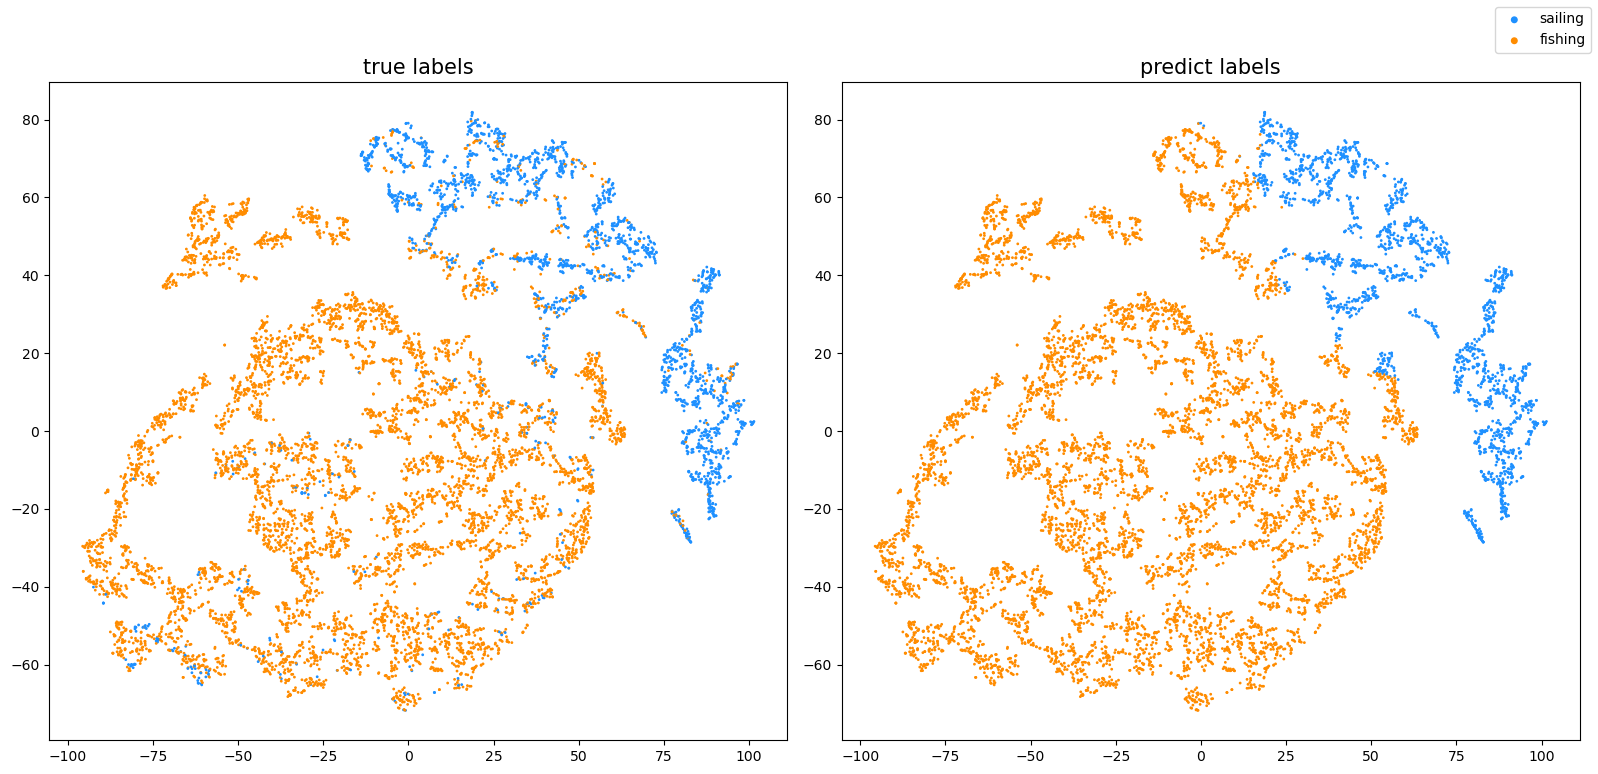

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(X_tsne5[:,0],X_tsne5[:,1], c = color[lab_true], s=1)
ax[0].set_title("true labels", fontsize=15)
# ax[0].legend()
ax[1].scatter(X_tsne5[:,0],X_tsne5[:,1], c = color[lab_pred], s=1)
ax[1].set_title("predict labels", fontsize=15)
# ax[1].legend(labels=le_pred)

# fig.tight_layout()
fig.legend(labels=np.array(["sailing", "fishing"]), loc='upper right', markerscale=4)
# fig.suptitle("Clustering results for TCN blocks without combination operation")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [240]:
DD["lab_pre5"] = pred5.reshape(-1)

### model6

In [74]:
# m6.load_state_dict(torch.load("parameters/baseline_DRNN_com3.pkl"))

<All keys matched successfully>

In [75]:
Hs6 = []
for i in range(0, 4):
    m6.eval()
    hs6= m6(Fs_p[i * 2000:(i + 1) * 2000])
    hs6 = hs6[:,-1,:].squeeze()
    Hs6.append(hs6.detach().numpy())

m6.eval()
hs6 = m6(Fs_p[4 * 2000:])
hs6 = hs6[:,-1,:].squeeze()
Hs6.append(hs6.detach().numpy())

Hs6 = np.concatenate(Hs6, axis=0)

In [76]:
tsne6 = TSNE(n_components=2, init='pca', random_state=0)
X_tsne6 = tsne6.fit_transform(Hs6)

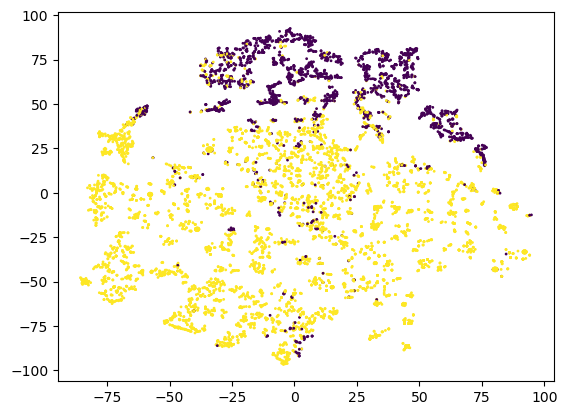

In [51]:
plt.scatter(X_tsne6[:,0],X_tsne6[:,1], c = np.array(Lab_p), s=1)

In [77]:
n_clusters = 2
cluster6 = KMeans(n_clusters = n_clusters, random_state = 0).fit(Hs6)
y_pred6 = cluster6.labels_

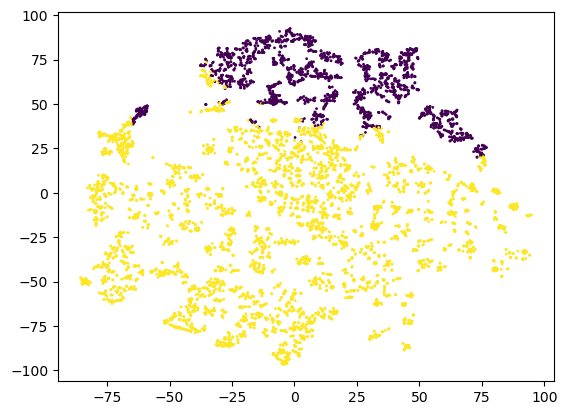

In [54]:
plt.scatter(X_tsne6[:,0],X_tsne6[:,1], c = np.array(y_pred6), s=1)

In [300]:
np.sum(y_pred6 == np.array(Lab_p)) / len(y_pred6)

0.9264785971027121

In [302]:
Y_pred6 = []
for i in y_pred6:
    if i == 0:
        Y_pred6.append([0] * 100)
    else:
        Y_pred6.append([1] * 100)

In [303]:
Y_pred6 = np.stack(Y_pred6, axis=0)

y_true = LL_p.reshape(-1)
pred6 = Y_pred6.reshape(-1)


accuracy = accuracy_score(y_true, pred6)
print("Accuracy:", accuracy)


conf_matrix = confusion_matrix(y_true, pred6)
print("Confusion Matrix:")
print(conf_matrix)


precision = precision_score(y_true, pred6)
recall = recall_score(y_true, pred6)
f1 = f1_score(y_true, pred6)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


fpr, tpr, thresholds = roc_curve(y_true, pred6)
roc_auc = roc_auc_score(y_true, pred6)
print("AUC:", roc_auc)

Accuracy: 0.9240137239952075
Confusion Matrix:
[[189250  41513]
 [ 28250 659087]]
Precision: 0.9407465029974308
Recall: 0.9588993463177452
F1 Score: 0.9497361911959981
AUC: 0.8895024112494677


In [78]:
lab_true = np.array(Lab_p)
lab_pred = np.array(y_pred6)

le_true = np.array(["sailing"] * len(lab_true))
# le_true[lab_true == 0] = "sailing"
le_true[lab_true == 1] = "fishing"

le_pred = np.array(["sailing"] * len(lab_pred))
# le_pred[lab_pred == 0] = "sailing"
le_pred[lab_pred == 1] = "fishing"

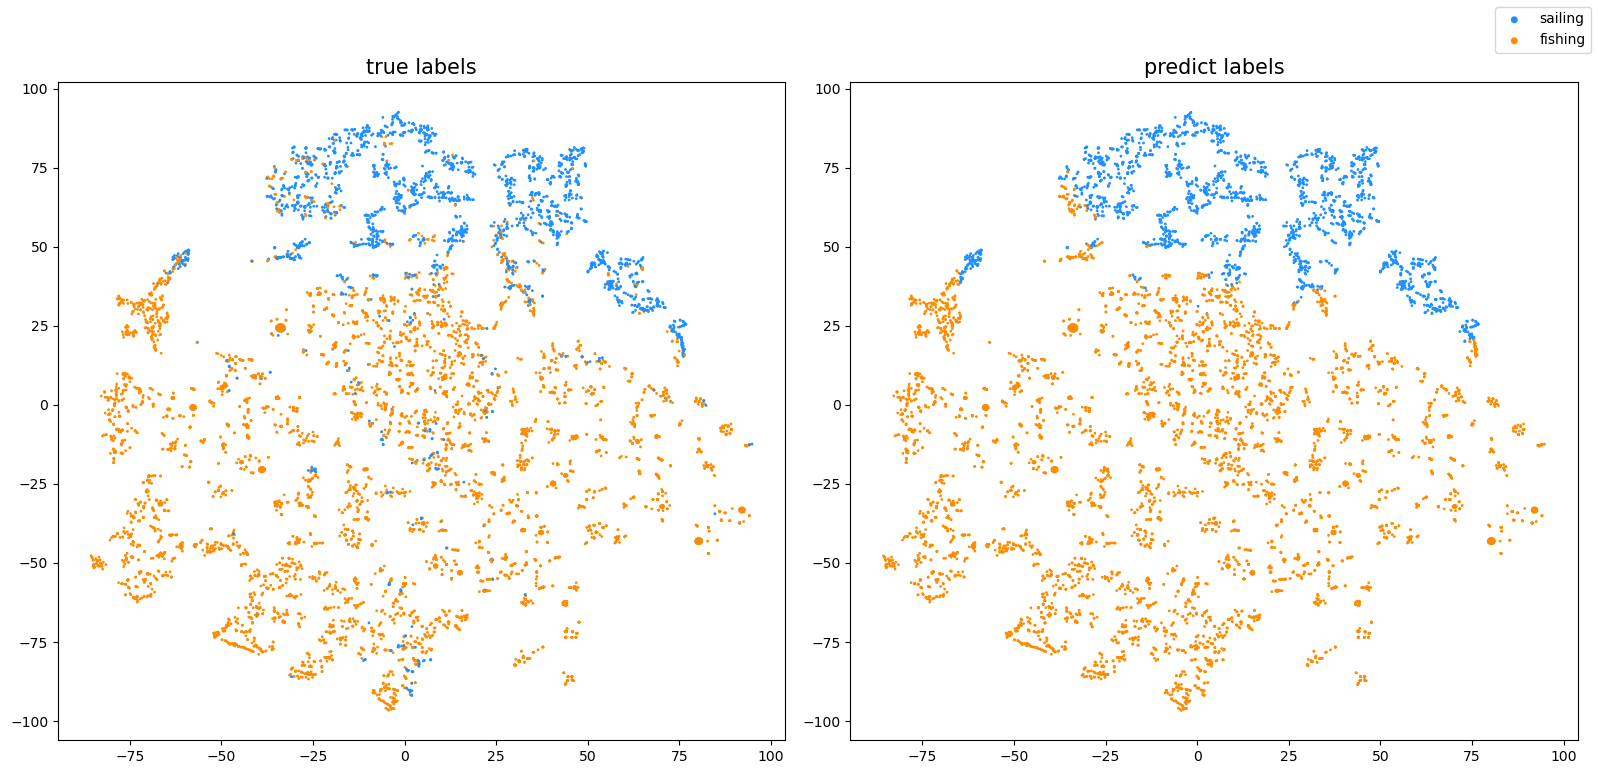

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(X_tsne6[:,0],X_tsne6[:,1], c = color[lab_true], s=1)
ax[0].set_title("true labels", fontsize=15)
# ax[0].legend()
ax[1].scatter(X_tsne6[:,0],X_tsne6[:,1], c = color[lab_pred], s=1)
ax[1].set_title("predict labels", fontsize=15)
# ax[1].legend(labels=le_pred)

# fig.tight_layout()
fig.legend(labels=np.array(["sailing", "fishing"]), loc='upper right', markerscale=4)
# fig.suptitle("Clustering results for TCN blocks without combination operation")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [306]:
DD["lab_pre6"] = pred6.reshape(-1)

### model7

In [80]:
# m7.load_state_dict(torch.load("parameters/model_drnn_dis2.pkl"))

<All keys matched successfully>

In [81]:
Hs7 = []
for i in range(0, 4):
    m7.eval()
    hs7= m7(Fs_p[i * 2000:(i + 1) * 2000])
    hs7 = hs7[:,-1,:].squeeze()
    Hs7.append(hs7.detach().numpy())

m7.eval()
hs7 = m7(Fs_p[4 * 2000:])
hs7 = hs7[:,-1,:].squeeze()
Hs7.append(hs7.detach().numpy())

Hs7 = np.concatenate(Hs7, axis=0)

In [82]:
tsne7 = TSNE(n_components=2, init='pca', random_state=0)
X_tsne7 = tsne7.fit_transform(Hs7)

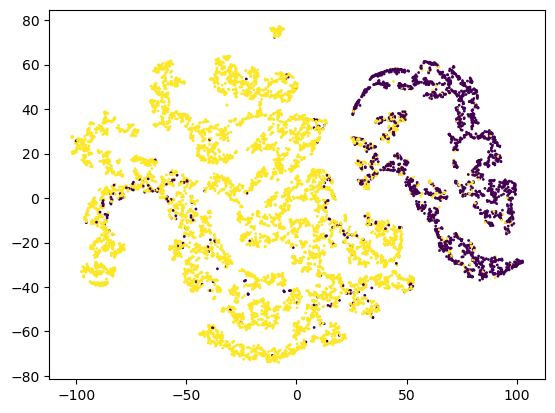

In [58]:
plt.scatter(X_tsne7[:,0],X_tsne7[:,1], c = np.array(Lab_p), s=1)

In [83]:
m7.eval()
y_pred7= np.argmax(m7.sim(torch.tensor(Hs7)).detach().numpy(), axis=-1)

In [84]:
y_pred7[y_pred7==0] = 2
y_pred7[y_pred7==1] = 0
y_pred7[y_pred7==2] = 1

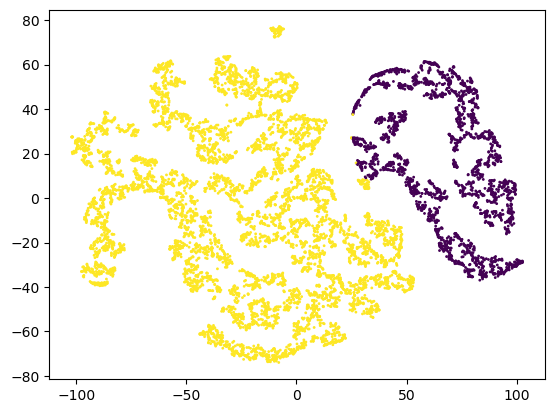

In [61]:
plt.scatter(X_tsne7[:,0],X_tsne7[:,1], c = np.array(y_pred7), s=1)

In [334]:
np.sum(y_pred7 == np.array(Lab_p)) / len(y_pred7)

0.9368260538067749

In [335]:
Y_pred7 = []
for i in y_pred7:
    if i == 0:
        Y_pred7.append([0] * 100)
    else:
        Y_pred7.append([1] * 100)

In [336]:
Y_pred7 = np.stack(Y_pred7, axis=0)

y_true = LL_p.reshape(-1)
pred7 = Y_pred7.reshape(-1)


accuracy = accuracy_score(y_true, pred7)
print("Accuracy:", accuracy)


conf_matrix = confusion_matrix(y_true, pred7)
print("Confusion Matrix:")
print(conf_matrix)


precision = precision_score(y_true, pred7)
recall = recall_score(y_true, pred7)
f1 = f1_score(y_true, pred7)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


fpr, tpr, thresholds = roc_curve(y_true, pred7)
roc_auc = roc_auc_score(y_true, pred7)
print("AUC:", roc_auc)

Accuracy: 0.9345833787169153
Confusion Matrix:
[[204552  26211]
 [ 33848 653489]]
Precision: 0.9614373988524348
Recall: 0.9507548698818774
F1 Score: 0.9560662952063478
AUC: 0.9185854015560374


In [85]:
lab_true = np.array(Lab_p)
lab_pred = np.array(y_pred7)

le_true = np.array(["sailing"] * len(lab_true))
# le_true[lab_true == 0] = "sailing"
le_true[lab_true == 1] = "fishing"

le_pred = np.array(["sailing"] * len(lab_pred))
# le_pred[lab_pred == 0] = "sailing"
le_pred[lab_pred == 1] = "fishing"

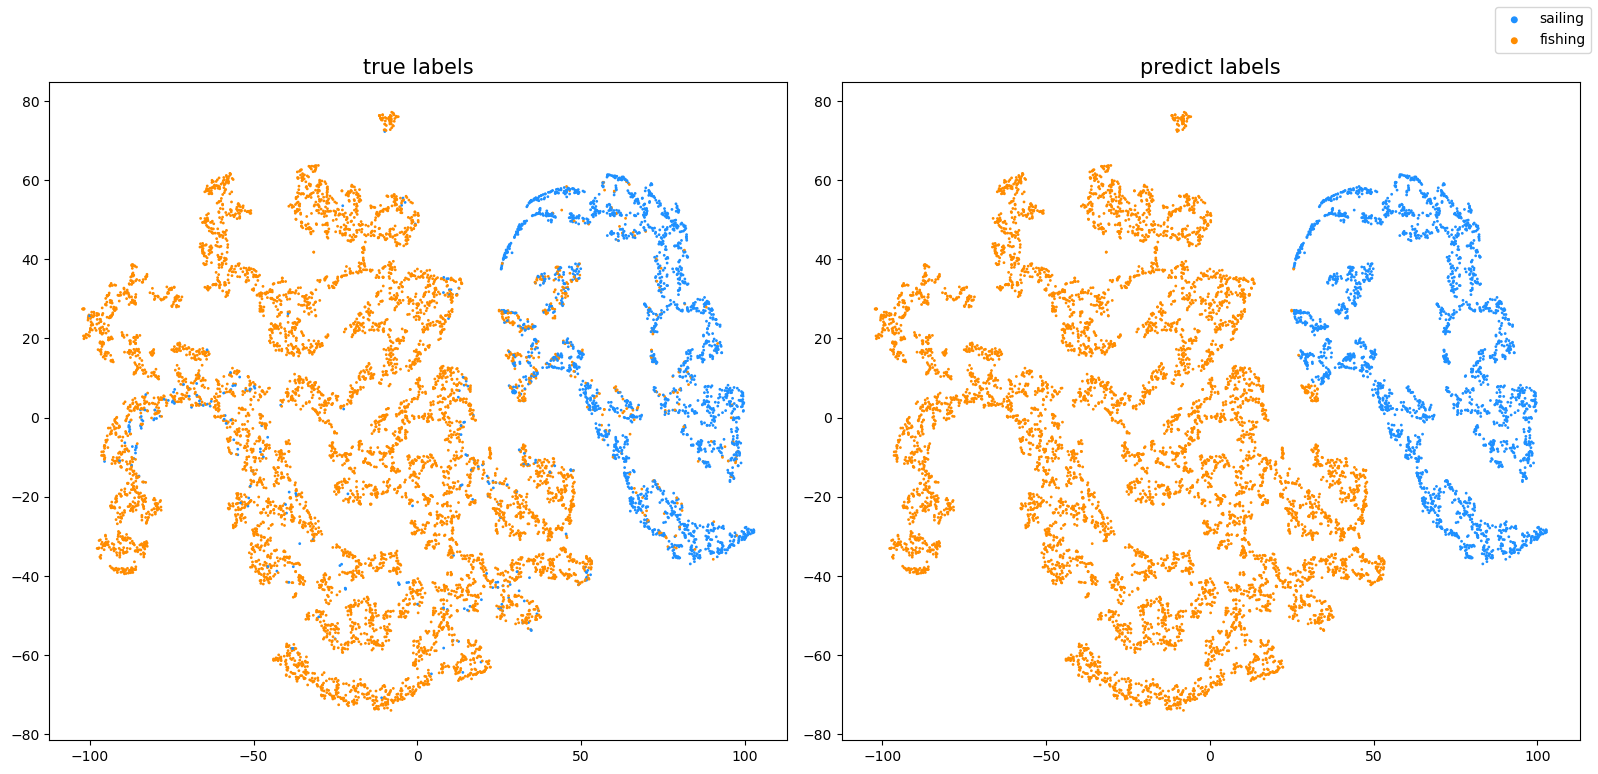

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(X_tsne7[:,0],X_tsne7[:,1], c = color[lab_true], s=1)
ax[0].set_title("true labels", fontsize=15)
# ax[0].legend()
ax[1].scatter(X_tsne7[:,0],X_tsne7[:,1], c = color[lab_pred], s=1)
ax[1].set_title("predict labels", fontsize=15)
# ax[1].legend(labels=le_pred)

# fig.tight_layout()
fig.legend(labels=np.array(["sailing", "fishing"]), loc='upper right', markerscale=4)
# fig.suptitle("Clustering results for TCN blocks without combination operation")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [339]:
DD["lab_pre7"] = pred7.reshape(-1)

### model8

In [87]:
# m8.load_state_dict(torch.load("parameters/model_drnn_com_dis1.pkl"))

<All keys matched successfully>

In [88]:
Hs8 = []
for i in range(0, 4):
    m8.eval()
    hs8= m8(Fs_p[i * 2000:(i + 1) * 2000])
    hs8 = hs8[:,-1,:].squeeze()
    Hs8.append(hs8.detach().numpy())

m8.eval()
hs8 = m8(Fs_p[4 * 2000:])
hs8 = hs8[:,-1,:].squeeze()
Hs8.append(hs8.detach().numpy())

Hs8 = np.concatenate(Hs8, axis=0)

In [89]:
tsne8 = TSNE(n_components=2, init='pca', random_state=0)
X_tsne8 = tsne8.fit_transform(Hs8)

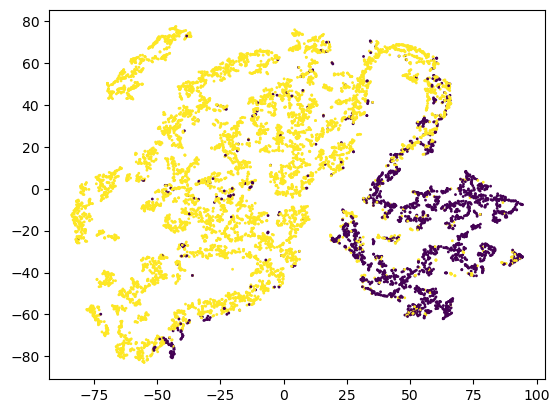

In [65]:
plt.scatter(X_tsne8[:,0],X_tsne8[:,1], c = np.array(Lab_p), s=1)

In [90]:
m8.eval()
y_pred8 = np.argmax(m8.sim(torch.tensor(Hs8)).detach().numpy(), axis=-1)

In [91]:
y_pred8[y_pred8==0] = 2
y_pred8[y_pred8==1] = 0
y_pred8[y_pred8==2] = 1

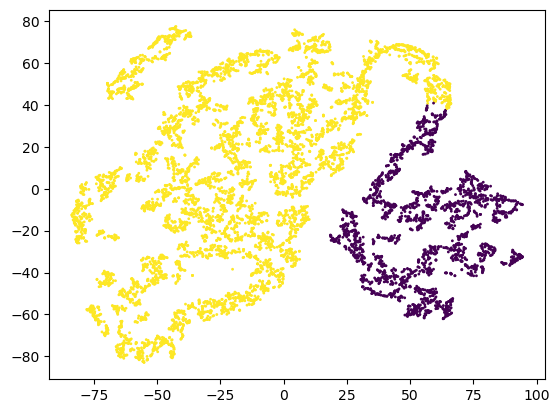

In [68]:
plt.scatter(X_tsne8[:,0],X_tsne8[:,1], c = np.array(y_pred8), s=1)

In [367]:
np.sum(y_pred8 == np.array(Lab_p)) / len(y_pred8)

0.9239734233743601

In [368]:
# 0.9239

In [369]:
Y_pred8 = []
for i in y_pred8:
    if i == 0:
        Y_pred8.append([0] * 100)
    else:
        Y_pred8.append([1] * 100)

In [371]:
Y_pred8 = np.stack(Y_pred8, axis=0)

y_true = LL_p.reshape(-1)
pred8 = Y_pred8.reshape(-1)


accuracy = accuracy_score(y_true, pred8)
print("Accuracy:", accuracy)


conf_matrix = confusion_matrix(y_true, pred8)
print("Confusion Matrix:")
print(conf_matrix)


precision = precision_score(y_true, pred8)
recall = recall_score(y_true, pred8)
f1 = f1_score(y_true, pred8)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


fpr, tpr, thresholds = roc_curve(y_true, pred8)
roc_auc = roc_auc_score(y_true, pred8)
print("AUC:", roc_auc)

Accuracy: 0.9216348981592419
Confusion Matrix:
[[200808  29955]
 [ 41992 645345]]
Precision: 0.9556419369169258
Recall: 0.9389062424982214
F1 Score: 0.9472001714323038
AUC: 0.9045488688342954


In [92]:
lab_true = np.array(Lab_p)
lab_pred = np.array(y_pred8)

le_true = np.array(["sailing"] * len(lab_true))
# le_true[lab_true == 0] = "sailing"
le_true[lab_true == 1] = "fishing"

le_pred = np.array(["sailing"] * len(lab_pred))
# le_pred[lab_pred == 0] = "sailing"
le_pred[lab_pred == 1] = "fishing"

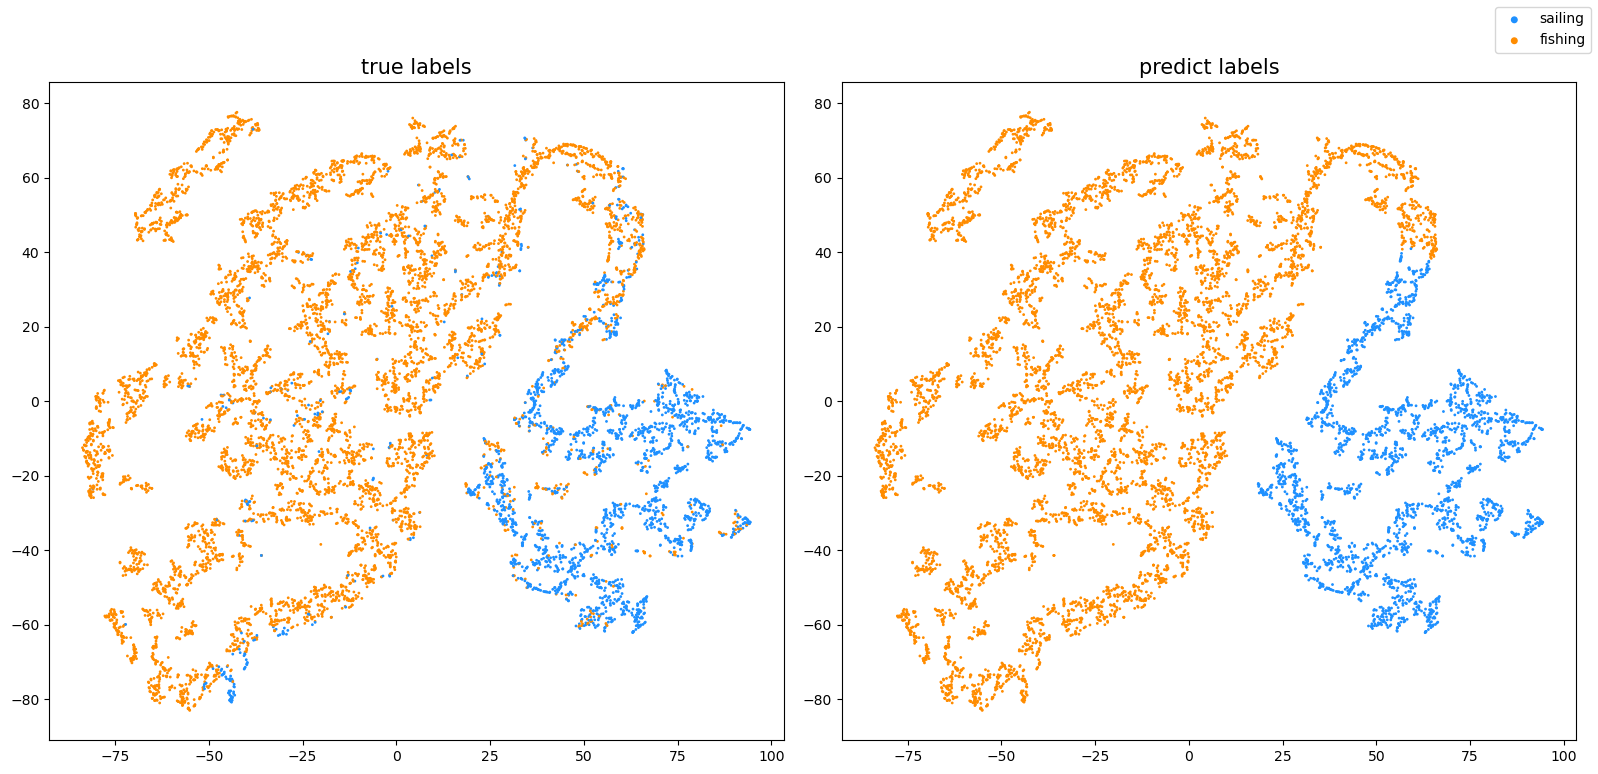

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(X_tsne8[:,0],X_tsne8[:,1], c = color[lab_true], s=1)
ax[0].set_title("true labels", fontsize=15)
# ax[0].legend()
ax[1].scatter(X_tsne8[:,0],X_tsne8[:,1], c = color[lab_pred], s=1)
ax[1].set_title("predict labels", fontsize=15)
# ax[1].legend(labels=le_pred)

# fig.tight_layout()
fig.legend(labels=np.array(["sailing", "fishing"]), loc='upper right', markerscale=4)
# fig.suptitle("Clustering results for TCN blocks without combination operation")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [374]:
DD["lab_pre8"] = pred8.reshape(-1)

In [375]:
DD.to_csv("data/result.csv", index=False)

## Plots

In [38]:
Labels = pd.read_csv("data/result.csv")

In [39]:
Labels

longitude   latitude  label  MMSI  lab_pre1  lab_pre2  lab_pre3  \
0       12.310170  56.127777      0     0         1         1         1   
1       12.310137  56.127788      0     0         1         1         1   
2       12.310103  56.127800      0     0         1         1         1   
3       12.310067  56.127815      0     0         1         1         1   
4       12.310025  56.127830      0     0         1         1         1   
...           ...        ...    ...   ...       ...       ...       ...   
918095   7.223698  56.042275      1   137         1         1         1   
918096   7.223630  56.042308      1   137         1         1         1   
918097   7.223395  56.042307      1   137         1         1         1   
918098   7.223197  56.042323      1   137         1         1         1   
918099   7.223037  56.042335      1   137         1         1         1   

        lab_pre4  lab_pre5  lab_pre6  lab_pre7  lab_pre8  
0              1         1         1         1         1  
1              1         1         1         1         1  
2              1         1         1         1         1  
3              1         1         1         1         1  
4              1         1         1         1         1  
...          ...       ...       ...       ...       ...  
918095         1         1         1         1         1  
918096         1         1         1         1         1  
918097         1         1         1         1         1  
918098         1         1         1         1         1  
918099         1         1         1         1         1  

[918100 rows x 12 columns]

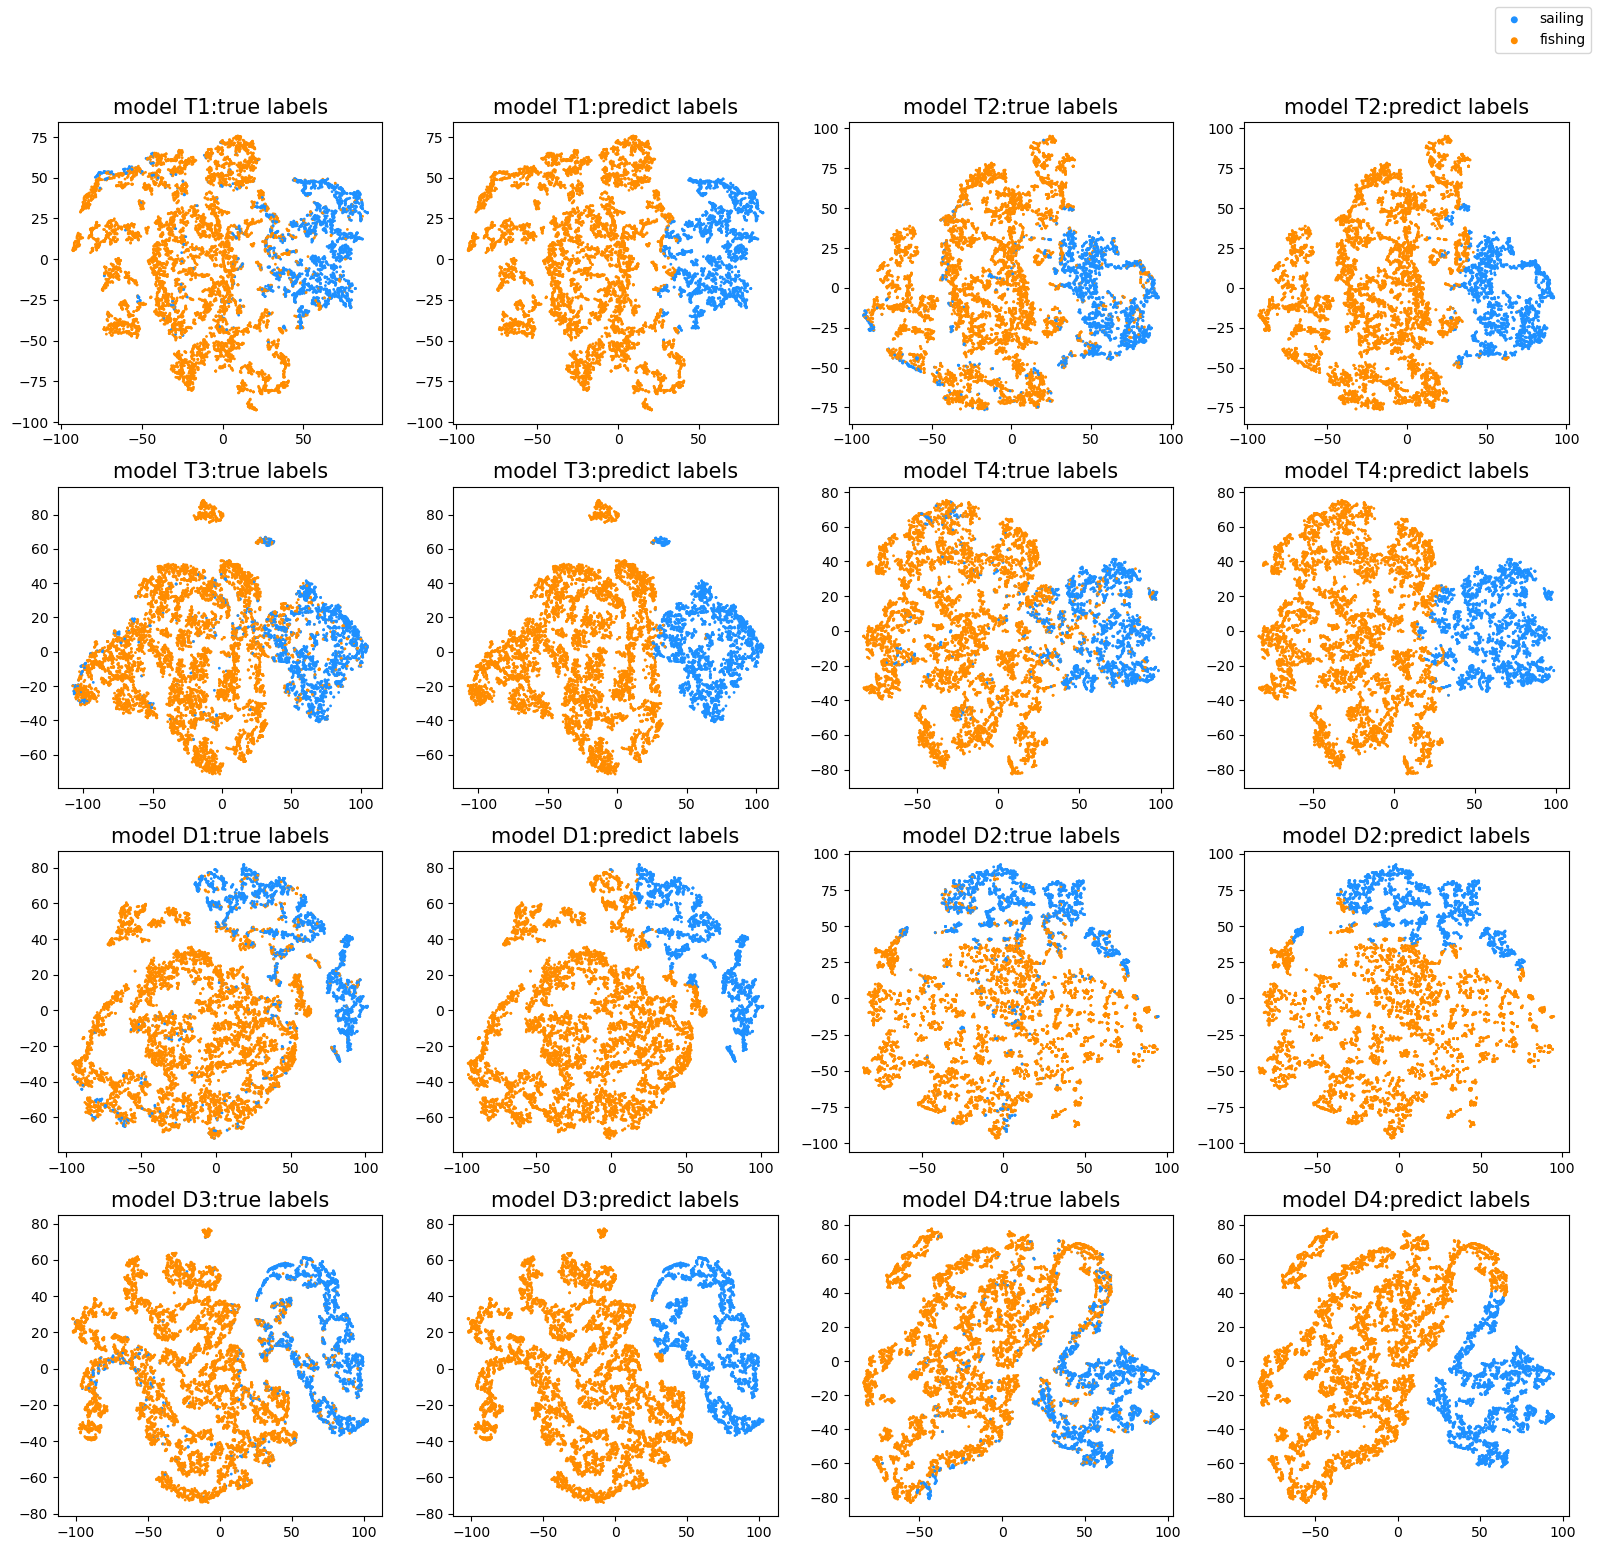

In [94]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
ax[0][0].scatter(X_tsne1[:,0],X_tsne1[:,1], c = color[np.array(Lab_p)], s=1)
ax[0][0].set_title("model T1:true labels", fontsize=15)
# ax[0].legend()
ax[0][1].scatter(X_tsne1[:,0],X_tsne1[:,1], c = color[y_pred1], s=1)
ax[0][1].set_title("model T1:predict labels", fontsize=15)
# fig.suptitle('model1', fontsize=16)

ax[0][2].scatter(X_tsne2[:,0],X_tsne2[:,1], c = color[np.array(Lab_p)], s=1)
ax[0][2].set_title("model T2:true labels", fontsize=15)
# ax[0].legend()
ax[0][3].scatter(X_tsne2[:,0],X_tsne2[:,1], c = color[y_pred2], s=1)
ax[0][3].set_title("model T2:predict labels", fontsize=15)
# fig.suptitle('model2', fontsize=16)

ax[1][0].scatter(X_tsne3[:,0],X_tsne3[:,1], c = color[np.array(Lab_p)], s=1)
ax[1][0].set_title("model T3:true labels", fontsize=15)
# ax[0].legend()
ax[1][1].scatter(X_tsne3[:,0],X_tsne3[:,1], c = color[y_pred3], s=1)
ax[1][1].set_title("model T3:predict labels", fontsize=15)
# fig.suptitle('model3', fontsize=16)

ax[1][2].scatter(X_tsne4[:,0],X_tsne4[:,1], c = color[np.array(Lab_p)], s=1)
ax[1][2].set_title("model T4:true labels", fontsize=15)
# ax[0].legend()
ax[1][3].scatter(X_tsne4[:,0],X_tsne4[:,1], c = color[y_pred4], s=1)
ax[1][3].set_title("model T4:predict labels", fontsize=15)
# fig.suptitle('model4', fontsize=16)

ax[2][0].scatter(X_tsne5[:,0],X_tsne5[:,1], c = color[np.array(Lab_p)], s=1)
ax[2][0].set_title("model D1:true labels", fontsize=15)
# ax[0].legend()
ax[2][1].scatter(X_tsne5[:,0],X_tsne5[:,1], c = color[y_pred5], s=1)
ax[2][1].set_title("model D1:predict labels", fontsize=15)
# fig.suptitle('model5', fontsize=16)

ax[2][2].scatter(X_tsne6[:,0],X_tsne6[:,1], c = color[np.array(Lab_p)], s=1)
ax[2][2].set_title("model D2:true labels", fontsize=15)
# ax[0].legend()
ax[2][3].scatter(X_tsne6[:,0],X_tsne6[:,1], c = color[y_pred6], s=1)
ax[2][3].set_title("model D2:predict labels", fontsize=15)
# fig.suptitle('model6', fontsize=16)

ax[3][0].scatter(X_tsne7[:,0],X_tsne7[:,1], c = color[np.array(Lab_p)], s=1)
ax[3][0].set_title("model D3:true labels", fontsize=15)
# ax[0].legend()
ax[3][1].scatter(X_tsne7[:,0],X_tsne7[:,1], c = color[y_pred7], s=1)
ax[3][1].set_title("model D3:predict labels", fontsize=15)
# fig.suptitle('model7', fontsize=16)

ax[3][2].scatter(X_tsne8[:,0],X_tsne8[:,1], c = color[np.array(Lab_p)], s=1)
ax[3][2].set_title("model D4:true labels", fontsize=15)
# ax[0].legend()
ax[3][3].scatter(X_tsne8[:,0],X_tsne8[:,1], c = color[y_pred8], s=1)
ax[3][3].set_title("model D4:predict labels", fontsize=15)
# fig.suptitle('model8', fontsize=16)
# fig.tight_layout()
fig.legend(labels=np.array(["sailing", "fishing"]), loc='upper right', markerscale=4)
# fig.suptitle("Clustering results for TCN blocks without combination operation")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])